In [2]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier 

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import roc_auc_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
import shap
import seaborn as sns

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
bankruptcy = pd.read_csv("data.csv")
bankruptcy.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [24]:
# 10 największych korelacji z bankrutem
corr_mat = bankruptcy.corr().abs()["Bankrupt?"]

corr_mat.sort_values(ascending=False)[0:11]

Bankrupt?                                                   1.000000
 Net Income to Total Assets                                 0.315457
 ROA(A) before interest and % after tax                     0.282941
 ROA(B) before interest and depreciation after tax          0.273051
 ROA(C) before interest and depreciation before interest    0.260807
 Net worth/Assets                                           0.250161
 Debt ratio %                                               0.250161
 Persistent EPS in the Last Four Seasons                    0.219560
 Retained Earnings to Total Assets                          0.217779
 Net profit before tax/Paid-in capital                      0.207857
 Per Share Net profit before tax (Yuan ¥)                   0.201395
Name: Bankrupt?, dtype: float64

KeyError: 'Persistent EPS in the Last Four Seasons'

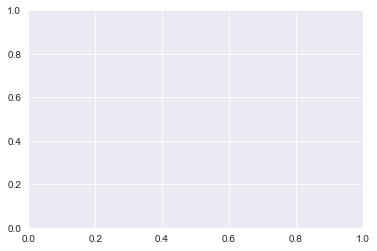

In [25]:
bankruptcy.plot.scatter(
        x='Persistent EPS in the Last Four Seasons',
        y='Persistent EPS in the Last Four Seasons'
    )

## Podział ramki danych

In [5]:
val_bankruptcy = pd.read_csv("data.csv")
X = bankruptcy.drop(["Bankrupt?"], axis=1)
y = bankruptcy["Bankrupt?"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

Preprossesing został wykonany jednakowy jak w zadaniu domowym 3

In [12]:
idx = np.where(bankruptcy.corr()["Bankrupt?"] <0)[0]
bankruptcy.iloc[:,idx] = -bankruptcy.iloc[:,idx]
pd.set_option('display.max_columns', None)
bankruptcy.corr()

bankruptcy = bankruptcy.drop(" Net Income Flag", axis = 1)

columns = X_train.drop(' Liability-Assets Flag', axis = 1).columns

for col in columns:
    lower = X_train[col].quantile(0.025)
    upper = X_train[col].quantile(0.975)
    
    
    X_train[col] = [lower if x < lower else x for x in X_train[col] ]
    X_train[col] = [upper if x > upper else x for x in X_train[col] ]
    X_test[col] = [lower if x < lower else x for x in X_test[col] ]
    X_test[col] = [upper if x > upper else x for x in X_test[col] ]

AttributeError: 'numpy.ndarray' object has no attribute 'drop'

In [33]:
X_train.describe()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4.773000e+03,4.773000e+03,4773.000000,4.773000e+03,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4.773000e+03,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4.773000e+03,4.773000e+03,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4.773000e+03,4.773000e+03,4773.000000,4.773000e+03,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.0,4773.000000
mean,0.504830,0.558379,0.553485,0.608063,0.608031,0.999014,0.797439,0.809350,0.303523,0.781608,1.959282e+09,1.941191e+09,0.467097,2.753824e+06,0.108944,0.188938,0.188940,0.188973,0.227614,0.323

### Normalizacja
Zmieniamy zmienne na wartości z przedziału [0,1]

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [10]:
scaler.fit(X_train)

MinMaxScaler()

In [11]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Modele

In [14]:
def Consuse_Matrix(model):
    plot_confusion_matrix(model, X_test, y_test) 
    plt.gcf().set_size_inches(6, 5)
    plt.show()

## Decission Trees

In [47]:
from sklearn import tree


clf = tree.DecisionTreeClassifier()
optimization_dict = {
                        "min_impurity_decrease": [0, 0.2, 0.3, 0.4],
                        "max_depth": [80, 90, 100, 110],
                        "min_samples_leaf": [2, 5, 8, 10],
                        "max_leaf_nodes": [50, 100, 200]
                    }


### Random search

In [48]:
from sklearn.model_selection import RandomizedSearchCV

clf_random = RandomizedSearchCV(estimator = clf,

param_distributions = optimization_dict,
               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring = 'balanced_accuracy')
clf_random.fit(X, y)

# this prints the contents of the parameters in the optimization_dict
print ('optimization dict: ', optimization_dict, '\n')

# print the best parameters
print ('Best Parameters: ', clf_random.best_params_, ' \n')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
optimization dict:  {'min_impurity_decrease': [0, 0.2, 0.3, 0.4], 'max_depth': [80, 90, 100, 110], 'min_samples_leaf': [2, 5, 8, 10], 'max_leaf_nodes': [50, 100, 200]} 

Best Parameters:  {'min_samples_leaf': 5, 'min_impurity_decrease': 0, 'max_leaf_nodes': 50, 'max_depth': 110}  



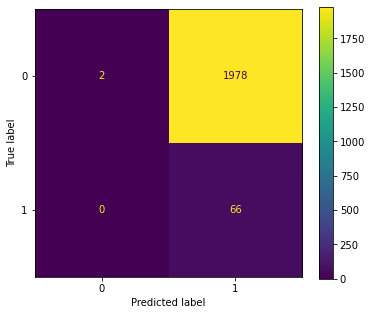

In [49]:
Consuse_Matrix(clf_random)

### Grid Search

In [50]:
from sklearn.model_selection import GridSearchCV

clf = tree.DecisionTreeClassifier()
clf_Grid = GridSearchCV(clf, optimization_dict, 
                     scoring='balanced_accuracy', verbose=1)
clf_Grid.fit(X, y)

# this prints the contents of the parameters in the optimization_dict
print ('optimization dict: ', optimization_dict, '\n')

# print the best parameters
print ('Best Parameters: ', clf_Grid.best_params_, ' \n')

Fitting 5 folds for each of 192 candidates, totalling 960 fits
optimization dict:  {'min_impurity_decrease': [0, 0.2, 0.3, 0.4], 'max_depth': [80, 90, 100, 110], 'min_samples_leaf': [2, 5, 8, 10], 'max_leaf_nodes': [50, 100, 200]} 

Best Parameters:  {'max_depth': 80, 'max_leaf_nodes': 100, 'min_impurity_decrease': 0, 'min_samples_leaf': 5}  



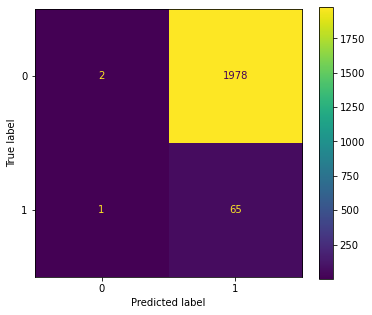

In [51]:
Consuse_Matrix(clf_Grid)

##  Random Forest

In [30]:
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier()
optimization_dict = {
                        'bootstrap': [True],
                        'max_depth': [80, 90, 100, 110],
                        'max_features': [2, 3],
                        'min_samples_split': [8, 10, 12],
                        'n_estimators': [100, 200, 300, 1000]
                    }



### Random Search

In [31]:
from sklearn.model_selection import RandomizedSearchCV

rl_random = RandomizedSearchCV(estimator = rf_model, 
                               param_distributions = optimization_dict,
                               random_state = 35,
                               scoring = 'balanced_accuracy')

rl_random.fit(X, y)

# this prints the contents of the parameters in the optimization_dict
print ('optimization dict: ', optimization_dict, '\n')

# print the best parameters
print ('Best Parameters: ', rl_random.best_params_, ' \n')

optimization dict:  {'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300, 1000]} 

Best Parameters:  {'n_estimators': 300, 'min_samples_split': 12, 'max_features': 3, 'max_depth': 110, 'bootstrap': True}  



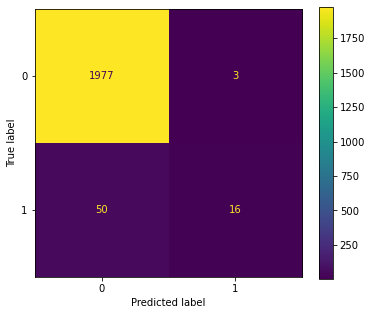

In [32]:
Consuse_Matrix(rl_random)

### Grind Search

In [33]:
rf = GridSearchCV(rf_model, optimization_dict, 
                     scoring='balanced_accuracy', verbose=1)

rf.fit(X_train, y_train)

# this prints the contents of the parameters in the optimization_dict
print ('optimization dict: ', optimization_dict, '\n')

# print the best parameters
print ('Best Parameters: ', rf.best_params_, ' \n')

Fitting 5 folds for each of 96 candidates, totalling 480 fits
optimization dict:  {'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300, 1000]} 

Best Parameters:  {'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_split': 8, 'n_estimators': 200}  



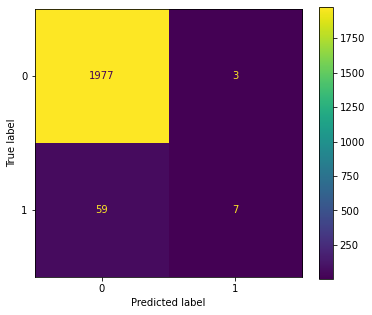

In [34]:
Consuse_Matrix(rf)

## Support Vector Machine

In [35]:
from sklearn import svm

# defining parameter range
optimization_dict = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

svm = svm.SVC()

### Random Search

In [36]:
from sklearn.model_selection import RandomizedSearchCV

svm_random = RandomizedSearchCV(estimator = svm,
param_distributions = optimization_dict,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1, scoring = 'balanced_accuracy')

svm_random.fit(X, y)

# this prints the contents of the parameters in the optimization_dict
print ('optimization dict: ', optimization_dict, '\n')

# print the best parameters
print ('Best Parameters: ', svm_random.best_params_, ' \n')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
optimization dict:  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']} 

Best Parameters:  {'kernel': 'rbf', 'gamma': 1, 'C': 0.1}  



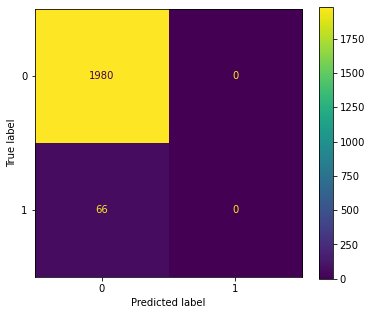

In [37]:
Consuse_Matrix(svm_random)

### Grind Search

In [38]:
from sklearn.model_selection import GridSearchCV
 
grid = GridSearchCV(svm, optimization_dict, refit = True, verbose = 3, scoring = 'balanced_accuracy')
 
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.603 total time=   0.2s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.589 total time=   0.2s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.653 total time=   0.3s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.573 total time=   0.3s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.605 total time=   0.4s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.670 total time=   0.3s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.625 total time=   0.4s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.660 total time=   0.3s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.527 total time=   0.3s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.499 total time=   0.1s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.499 total time=   0.1s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.531 total time=   0.1s
[CV 4/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='balanced_accuracy', verbose=3)

In [40]:
# this prints the contents of the parameters in the optimization_dict
print ('optimization dict: ', optimization_dict, '\n')

# print the best parameters
print ('Best Parameters: ', grid.best_params_, ' \n')

optimization dict:  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']} 

Best Parameters:  {'C': 100, 'gamma': 1, 'kernel': 'rbf'}  



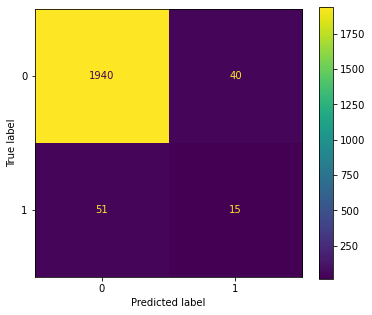

In [41]:
Consuse_Matrix(grid)